In [1]:
import sys
sys.path.append('..')
import torch
import numpy as np
import matplotlib.pyplot as plt
from sympy import simplify_logic

from deep_logic.utils.base import validate_network
from deep_logic.utils.relunn import get_reduced_model
from deep_logic import fol

torch.manual_seed(0)
np.random.seed(0)

In [2]:
# XOR problem
x_train = torch.tensor([
    [0, 0],
    [0, 1],
    [1, 0],
    [1, 1],
], dtype=torch.float)
y_train = torch.tensor([0, 1, 1, 0], dtype=torch.float).unsqueeze(1)


x_test = torch.tensor([
    [0, 0.95],
    [0, 0.9],
    [0.05, 1],
    [0.1, 0.8],
    [0.45, 1],
    [0, 0.35],
    [0.95, 0.9],
    [0.75, 0.2],
    [0.75, 0.15],
], dtype=torch.float)
y_test = torch.tensor([1, 1, 1, 1, 1, 0, 0, 1, 1], dtype=torch.float).unsqueeze(1)

In [3]:
layers = [
    torch.nn.Linear(x_train.size(1), 10),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(10, 4),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(4, 1),
    torch.nn.Sigmoid(),
]
model = torch.nn.Sequential(*layers)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
model.train()
need_pruning = True
for epoch in range(1000):
    # forward pass
    optimizer.zero_grad()
    y_pred = model(x_train)
    # Compute Loss
    loss = torch.nn.functional.mse_loss(y_pred, y_train)

    for module in model.children():
        if isinstance(module, torch.nn.Linear):
            loss += 0.001 * torch.norm(module.weight, 1)

    # backward pass
    loss.backward()
    optimizer.step()

    # compute accuracy
    if epoch % 100 == 0:
        y_pred_d = (y_pred > 0.5)
        accuracy = (y_pred_d.eq(y_train).sum(dim=1) == y_train.size(1)).sum().item() / y_train.size(0)
        print(f'Epoch {epoch}: train accuracy: {accuracy:.4f}')

Epoch 0: train accuracy: 0.5000
Epoch 100: train accuracy: 1.0000
Epoch 200: train accuracy: 1.0000
Epoch 300: train accuracy: 1.0000
Epoch 400: train accuracy: 1.0000
Epoch 500: train accuracy: 1.0000
Epoch 600: train accuracy: 1.0000
Epoch 700: train accuracy: 1.0000
Epoch 800: train accuracy: 1.0000
Epoch 900: train accuracy: 1.0000


# Decision boundaries

In [4]:
def plot_decision_bundaries(model, x, h=0.1, cmap='BrBG'):
    x1_min, x1_max = x[:, 0].min() - 1, x[:, 0].max() + 1
    x2_min, x2_max = x[:, 1].min() - 1, x[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, h),
                           np.arange(x2_min, x2_max, h))
    xx = torch.FloatTensor(np.c_[xx1.ravel(), xx2.ravel()])
    Z = model(xx).detach().numpy()
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.2, cmap=cmap)
    return

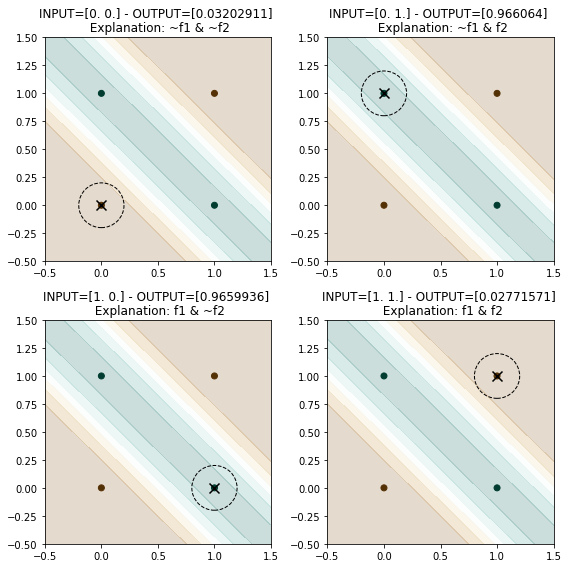

In [5]:
cmap = 'BrBG'
plt.figure(figsize=[8, 8])
for sample_id, (xin, yin) in enumerate(zip(x_train, y_train)):
    output = model(xin)
    explanation = fol.relunn.explain_local(model, x_train, y_train, 
                                           xin, yin, is_pruned=True, 
                                           concept_names=['f1', 'f2'])

    plt.subplot(2, 2, sample_id+1)
    plt.title(f'INPUT={xin.detach().numpy()} - OUTPUT={output.detach().numpy()} \n Explanation: {explanation}')
    plot_decision_bundaries(model, x_train, h=0.01)
    plt.scatter(x_train[:, 0].detach().numpy(), x_train[:, 1].detach().numpy(), c=y_train.detach().numpy(), cmap=cmap)
    plt.scatter(xin[0], xin[1], c='k', marker='x', s=100, cmap=cmap)
    c = plt.Circle((xin[0], xin[1]), radius=0.2, edgecolor='k', fill=False, linestyle='--')
    plt.gca().add_artist(c)
    plt.xlim([-0.5, 1.5])
    plt.ylim([-0.5, 1.5])
plt.tight_layout()
plt.show()

# Combine local explanations

In [6]:
for i, target_class in enumerate(range(2)):
    global_explanation, _, _ = fol.relunn.combine_local_explanations(model, x_train, y_train, 
                                                                     target_class=target_class,
                                                                     is_pruned=True)
    accuracy, preds = fol.base.test_explanation(global_explanation, target_class, x_test, y_test)
    final_formula = fol.base.replace_names(global_explanation, ['f1', 'f2'])
    print(f'Class {target_class} - Global explanation: "{final_formula}" - Accuracy: {accuracy:.4f}')

Class 0 - Global explanation: "(f1 & f2) | (~f1 & ~f2)" - Accuracy: 1.0000
Class 1 - Global explanation: "(f1 & ~f2) | (f2 & ~f1)" - Accuracy: 1.0000
